In [29]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sktime.transformations.series.outlier_detection import HampelFilter
import statsmodels.api as sm
import pandas_datareader.data as web
import statsmodels.formula.api as smf
import xlwings as xw
import numpy as np
import tempfile
import os


In [30]:
book = xw.Book('Richspread.xlsx') 
sht = book.sheets['Five_Factors']

In [31]:
sht.range('B2')
sht.range('B3')
sht.range('B4').value.strftime('%Y-%m-%d')
sht.range('B5').value.strftime('%Y-%m-%d')
print(sht.range('B2').value)
print(sht.range('B3').value)
print(sht.range('B4').value.strftime('%Y-%m-%d'))
print(sht.range('B5').value.strftime('%Y-%m-%d'))   

TSLA
^GSPC
2016-01-01
2025-07-14


In [32]:
# 2. Specify the risky asset, the benchmark, and the time horizon:
RISKY_ASSET = sht.range('B2').value
MARKET_BENCHMARK = sht.range('B3').value
START_DATE = sht.range('B4').value.strftime('%Y-%m-%d')
END_DATE = sht.range('B5').value.strftime('%Y-%m-%d')

# 3. Download the necessary data from Yahoo Finance:
factor_3_df = web.DataReader(
    "F-F_Research_Data_Factors",
    "famafrench",
    start=START_DATE,
    end=END_DATE
)[0]

# momentum factor
momentum_df = web.DataReader(
    "F-F_Momentum_Factor",
    "famafrench",
    start=START_DATE,
    end=END_DATE
)[0]

# five factors
factor_5_df = web.DataReader(
    "F-F_Research_Data_5_Factors_2x3",
    "famafrench",
    start=START_DATE,
    end=END_DATE
)[0]

# 4. Download the data of the risky asset from Yahoo Finance:
asset_df = yf.download(
    [RISKY_ASSET, MARKET_BENCHMARK],
    start=START_DATE,
    end=END_DATE,
    progress=False
    
)
# Prepare close_df from asset_df
close_df = asset_df['Close'].copy()
close_df.columns = ['asset', 'market']  # asset = AMZN, market = ^GSPC

# Resample to monthly returns
X = close_df.resample("M").last().pct_change().dropna()
covariance = X.cov().iloc[0, 1]
benchmark_variance = X['market'].var()
beta = covariance / benchmark_variance

# 5. Calculate the monthly returns:
# Use X as y, and convert index to PeriodIndex to match factor DataFrames
y = X.copy()
y.index = y.index.to_period("M")

# 6. Merge the datasets for the four-factor model:
# join all datasets on the index, use only asset returns
factor_4_df = factor_3_df.join(momentum_df).join(y["asset"])
# rename columns
factor_4_df.columns = ["mkt", "smb", "hml", "rf", "mom", "rtn"]
# divide everything (except returns) by 100
factor_4_df.loc[:, factor_4_df.columns != "rtn"] /= 100
# calculate excess returns
factor_4_df["excess_rtn"] = factor_4_df["rtn"] - factor_4_df["rf"]

# 7. Merge the datasets for the five-factor model:
# join all datasets on the index, use only asset returns
factor_5_df = factor_5_df.join(y["asset"])
# rename columns
factor_5_df.columns = [
    "mkt", "smb", "hml", "rmw", "cma", "rf", "rtn"
]
# divide everything (except returns) by 100
factor_5_df.loc[:, factor_5_df.columns != "rtn"] /= 100
# calculate excess returns
factor_5_df["excess_rtn"] = factor_5_df["rtn"] - factor_5_df["rf"]

# 8. Estimate the four-factor model:
four_factor_model = smf.ols(
    formula="excess_rtn ~ mkt + smb + hml + mom",
    data=factor_4_df
).fit()

# 9. Estimate the five-factor model:
five_factor_model = smf.ols(
    formula="excess_rtn ~ mkt + smb + hml + rmw + cma",
    data=factor_5_df
).fit()
print(five_factor_model.summary())
print(f"Beta: {beta:.4f}")

/var/folders/rx/whpr72693f3cgk151m8h7fh80000gn/T/ipykernel_69222/2860245385.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_3_df = web.DataReader(
/var/folders/rx/whpr72693f3cgk151m8h7fh80000gn/T/ipykernel_69222/2860245385.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_3_df = web.DataReader(
/var/folders/rx/whpr72693f3cgk151m8h7fh80000gn/T/ipykernel_69222/2860245385.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  momentum_df = web.DataReader(
/var/folders/rx/whpr72693f3cgk151m8h7fh80000gn/T/ipykernel_6

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     10.64
Date:                Mon, 14 Jul 2025   Prob (F-statistic):           2.65e-08
Time:                        13:43:50   Log-Likelihood:                 52.765
No. Observations:                 112   AIC:                            -93.53
Df Residuals:                     106   BIC:                            -77.22
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0247      0.015      1.605      0.1

/var/folders/rx/whpr72693f3cgk151m8h7fh80000gn/T/ipykernel_69222/2860245385.py:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  X = close_df.resample("M").last().pct_change().dropna()


In [33]:
# Get the full summary as text and split into lines
summary_lines = five_factor_model.summary().as_text().split('\n')

# Find the start and end of the coefficients table
start = None
end = None
for i, line in enumerate(summary_lines):
    if 'coef' in line and 'std err' in line:
        start = i - 1  # include the header line above the column names
    if start is not None and line.strip().startswith('Omnibus:'):
        end = i
        break

# Combine the top part and the coefficients table
if start is not None and end is not None:
    export_lines = summary_lines[:end]
else:
    export_lines = summary_lines  # fallback: export everything

# Write each line to Excel, splitting by whitespace, skipping separator lines
for i, line in enumerate(export_lines):
    if set(line.strip()) == {'='} or set(line.strip()) == {'-'} or not line.strip():
        continue  # skip separator or empty lines
    sht.range(f'F{6 + i}').value = line.split()

# Optional: Auto-fit columns for better appearance
sht.range('F:F').columns.autofit()

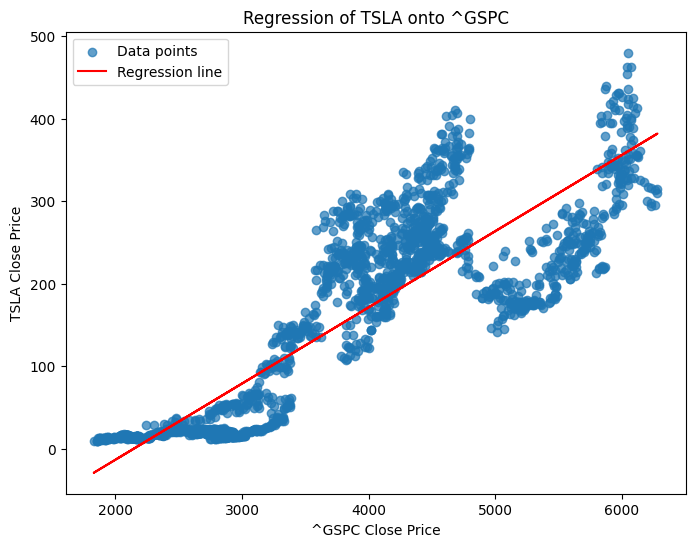

In [34]:
# Scatter plot and regression line for asset vs. market
import numpy as np
import matplotlib.pyplot as plt

# Use the monthly close prices
x = close_df['market']
y = close_df['asset']

# Fit regression line
slope, intercept = np.polyfit(x, y, 1)
reg_line = slope * x + intercept

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7, label='Data points')
plt.plot(x, reg_line, color='red', label='Regression line')
plt.xlabel(f"{MARKET_BENCHMARK} Close Price")
plt.ylabel(f"{RISKY_ASSET} Close Price")
plt.title(f"Regression of {RISKY_ASSET} onto {MARKET_BENCHMARK}")
plt.legend()
plt.show()

In [35]:
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmpfile:
    reg_chart_path = tmpfile.name

plt.figure(figsize=(8, 6))
plt.scatter(close_df['market'], close_df['asset'], alpha=0.7, label='Data points')
slope, intercept = np.polyfit(close_df['market'], close_df['asset'], 1)
reg_line = slope * close_df['market'] + intercept
plt.plot(close_df['market'], reg_line, color='red', label='Regression line')
plt.xlabel(f"{MARKET_BENCHMARK} Close Price")
plt.ylabel(f"{RISKY_ASSET} Close Price")
plt.title(f"Regression of {RISKY_ASSET} onto {MARKET_BENCHMARK}")
plt.legend()
plt.tight_layout()
plt.savefig(reg_chart_path, bbox_inches='tight')
plt.close()

# --- Export to Excel ---
book = xw.Book('Richspread.xlsx')
sht = book.sheets['Five_Factors']
sht.range('P3').value = f"Regression of {RISKY_ASSET} onto {MARKET_BENCHMARK}"
sht.pictures.add(reg_chart_path, name="RegressionChart", update=True,
                 left=sht.range('P3').left,
                 top=sht.range('P3').top)

# --- Optionally, remove the temp file after use ---
try:
    os.remove(reg_chart_path)
except Exception:
    pass